In [5]:
# Re-import required libraries after reset
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81
rho_0 = 1.225
H = 8500

# Rocket stats (Minuteman III)
stage = {
    'dry_mass': 10000,
    'fuel_mass': 26030,
    'burn_rate': 434,
    'T': 901000,
    'theta_deg': 45,
    'Cd': 0.2,
    'A': np.pi * (1.67 / 2)**2
}

burn_time = stage['fuel_mass'] / stage['burn_rate']
m0 = stage['dry_mass'] + stage['fuel_mass']
theta = np.radians(stage['theta_deg'])

# Drag function
def drag_vectorized(vx, vy, y, Cd, A):
    v = np.sqrt(vx**2 + vy**2)
    rho = rho_0 * np.exp(-y / H)
    rho[y >= 1e5] = 0
    D = 0.5 * rho * Cd * A * v
    return D * vx, D * vy

# ODE function
def rocket_ode(t, z):
    x, y, vx, vy, delta_v = z
    m = m0 - stage['burn_rate'] * t if t < burn_time else stage['dry_mass']
    T_x = stage['T'] * np.cos(theta) if t < burn_time else 0
    T_y = stage['T'] * np.sin(theta) if t < burn_time else 0
    D_x, D_y = drag_vectorized(np.array([vx]), np.array([vy]), np.array([y]), stage['Cd'], stage['A'])
    D_x, D_y = D_x[0], D_y[0]
    ax = (T_x - D_x) / m
    ay = (T_y - D_y) / m - g
    return np.array([vx, vy, ax, ay, np.sqrt(ax**2 + ay**2)])

# RK4 integration
def rk4(f, z0, t_span, dt):
    t_values = [t_span[0]]
    z_values = [np.array(z0)]

    t = t_span[0]
    z = np.array(z0)

    while t < t_span[1]:
        if t + dt > t_span[1]:
            dt = t_span[1] - t

        k1 = f(t, z)
        k2 = f(t + dt/2, z + dt * k1 / 2)
        k3 = f(t + dt/2, z + dt * k2 / 2)
        k4 = f(t + dt, z + dt * k3)

        z = z + dt * (k1 + 2*k2 + 2*k3 + k4) / 6
        t = t + dt

        t_values.append(t)
        z_values.append(z.copy())

    return np.array(t_values), np.array(z_values)

# Run RK4
t_rk4, z_rk4 = rk4(rocket_ode, [0, 0, 0, 0, 0], (0, 200), 0.1)
x, y = z_rk4[:, 0], z_rk4[:, 1]
vx, vy = z_rk4[:, 2], z_rk4[:, 3]
a = z_rk4[:, 4]
v = np.sqrt(vx**2 + vy**2)

D_x, D_y = drag_vectorized(vx, vy, y, stage['Cd'], stage['A'])
D = np.sqrt(D_x**2 + D_y**2)
thrust = np.where(t_rk4 < burn_time, stage['T'], 0)


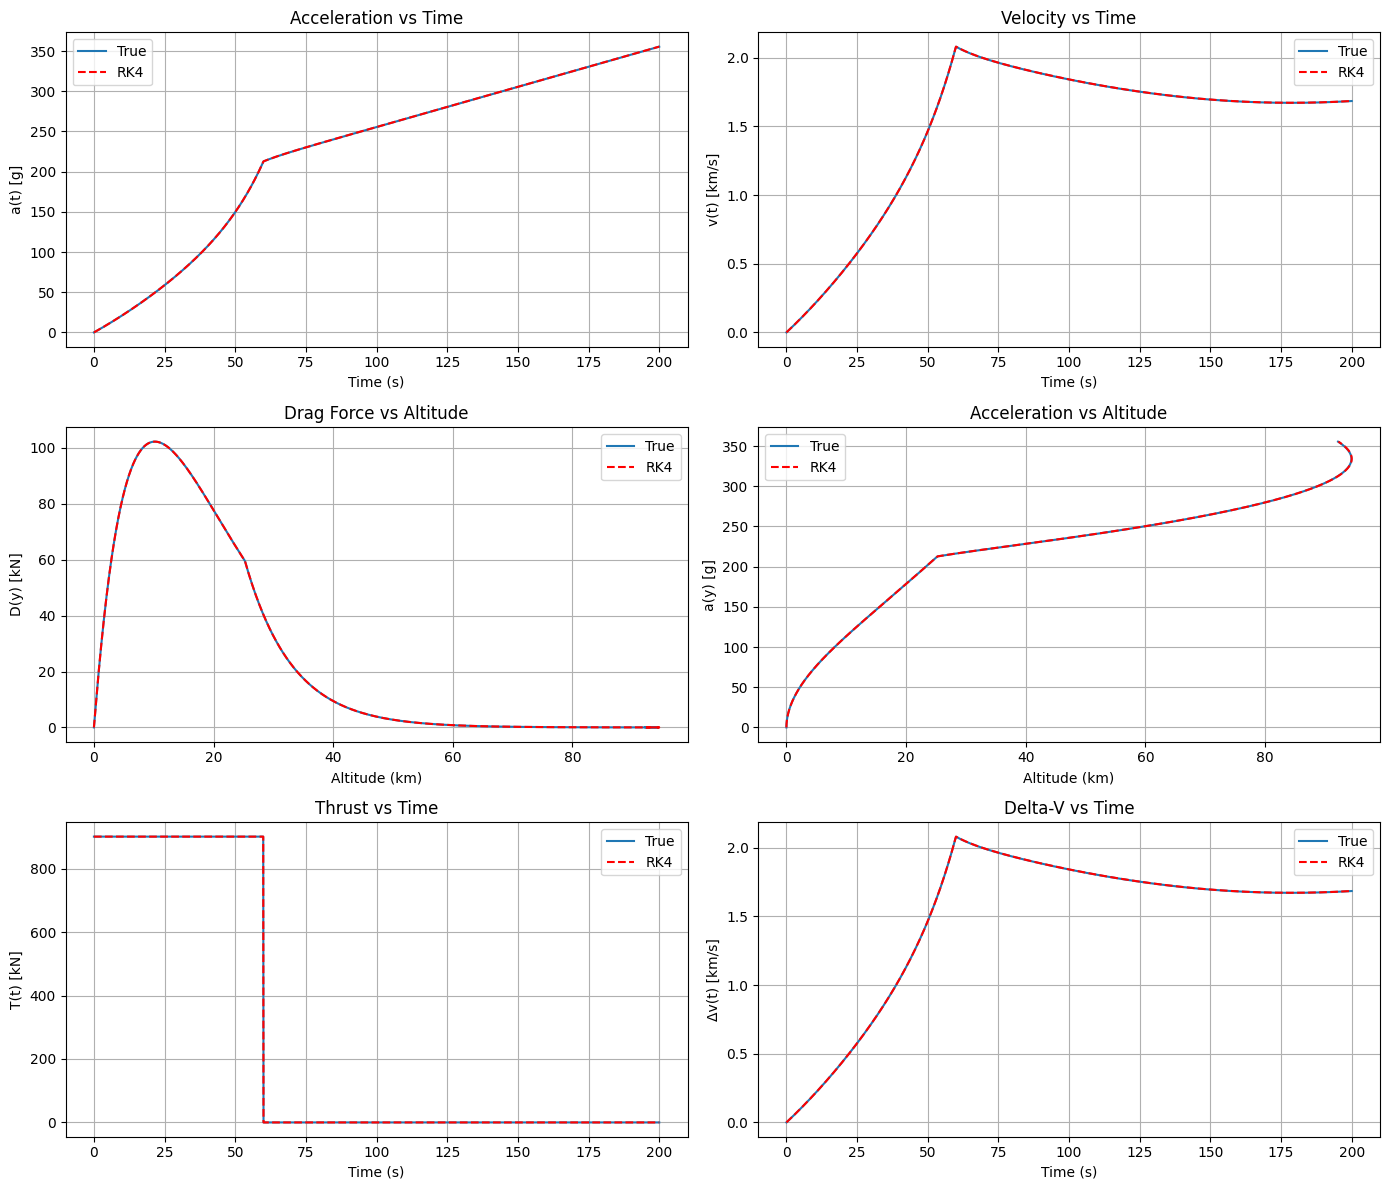

In [6]:
# "True" solution via high-res solve_ivp
from scipy.integrate import solve_ivp

# Use solve_ivp with tight tolerances as the reference "true" solution
sol_true = solve_ivp(rocket_ode, (0, 200), [0, 0, 0, 0, 0], t_eval=t_rk4, rtol=1e-10, atol=1e-10)

x_true, y_true = sol_true.y[0], sol_true.y[1]
vx_true, vy_true = sol_true.y[2], sol_true.y[3]
a_true = sol_true.y[4]
v_true = np.sqrt(vx_true**2 + vy_true**2)

D_xt, D_yt = drag_vectorized(vx_true, vy_true, y_true, stage['Cd'], stage['A'])
D_true = np.sqrt(D_xt**2 + D_yt**2)
thrust_true = np.where(sol_true.t < burn_time, stage['T'], 0)

# Plotting true vs RK4 (interpolated) solutions
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# 1. Acceleration vs Time
axs[0, 0].plot(sol_true.t, a_true / g, label='True')
axs[0, 0].plot(t_rk4, a / g, 'r--', label='RK4')
axs[0, 0].set_title("Acceleration vs Time")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("a(t) [g]")
axs[0, 0].grid(True)
axs[0, 0].legend()

# 2. Velocity vs Time
axs[0, 1].plot(sol_true.t, v_true / 1000, label='True')
axs[0, 1].plot(t_rk4, v / 1000, 'r--', label='RK4')
axs[0, 1].set_title("Velocity vs Time")
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("v(t) [km/s]")
axs[0, 1].grid(True)
axs[0, 1].legend()

# 3. Drag Force vs Altitude
axs[1, 0].plot(y_true / 1000, D_true / 1000, label='True')
axs[1, 0].plot(y / 1000, D / 1000, 'r--', label='RK4')
axs[1, 0].set_title("Drag Force vs Altitude")
axs[1, 0].set_xlabel("Altitude (km)")
axs[1, 0].set_ylabel("D(y) [kN]")
axs[1, 0].grid(True)
axs[1, 0].legend()

# 4. Acceleration vs Altitude
axs[1, 1].plot(y_true / 1000, a_true / g, label='True')
axs[1, 1].plot(y / 1000, a / g, 'r--', label='RK4')
axs[1, 1].set_title("Acceleration vs Altitude")
axs[1, 1].set_xlabel("Altitude (km)")
axs[1, 1].set_ylabel("a(y) [g]")
axs[1, 1].grid(True)
axs[1, 1].legend()

# 5. Thrust vs Time
axs[2, 0].plot(sol_true.t, thrust_true / 1000, label='True')
axs[2, 0].plot(t_rk4, thrust / 1000, 'r--', label='RK4')
axs[2, 0].set_title("Thrust vs Time")
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("T(t) [kN]")
axs[2, 0].grid(True)
axs[2, 0].legend()

# 6. Delta-V vs Time
axs[2, 1].plot(sol_true.t, v_true / 1000, label='True')
axs[2, 1].plot(t_rk4, v / 1000, 'r--', label='RK4')
axs[2, 1].set_title("Delta-V vs Time")
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("Î”v(t) [km/s]")
axs[2, 1].grid(True)
axs[2, 1].legend()

plt.tight_layout()
plt.show()
